In [3]:
import pandas as pd
import sys
sys.path.insert(0, "..")
from battleship.board import *
from battleship.spotter_model import Question, Answer, CodeSpotterModel, DirectSpotterModel, CODE_FAIL_STR
from battleship.prompting import SpotterPrompt
from tqdm import tqdm

In [4]:
def retrieve_context(question_id, round_data):
    question_history_data = round_data[round_data["questionID"] < question_id]
    question_data = round_data[round_data["questionID"] == question_id]

    #QUESTION AND ITS BOARD
    question_text = question_data[question_data["messageType"] == "question"]["messageText"].tolist()[0]
    question_captain_board = question_data[question_data["messageType"] == "question"]["occTiles"].tolist()[0]
    question_board_id = question_data[question_data["messageType"] == "question"]["board_id"].tolist()[0]
    ground_truth_answer = question_data[question_data["messageType"] == "answer"]["goldAnswer"].tolist()[0]

    #QUESTION HISTORY decision, question, answer, move
    #{"question":question, "code": q_ex.codestr, "answer": a_ex.text, "board_id": board}
    previous_decision_ids = sorted(list(set(question_history_data["questionID"].tolist())))

    examples = []
    for id in previous_decision_ids:
        decision, question, answer, move = None, None, None, None
        id_actions = question_history_data[question_history_data["questionID"] == id]
        try:
            decision = id_actions[id_actions["messageType"] == "decision"]["messageText"].tolist()[0]

            if decision == "question":
                question = id_actions[id_actions["messageType"] == "question"]["messageText"].tolist()[0]
                try:
                    answer = id_actions[id_actions["messageType"] == "answer"]["messageText"].tolist()[0]
                except:
                    answer = "Not answered"
            else:
                move = id_actions[id_actions["messageType"] == "move"]["messageText"].tolist()[0]
            
            dict_example = {"decision":decision, "question":question, "answer":answer, "move":move}
            examples.append(dict_example)
        except IndexError:
            if int(id) != 0:
                print(f"Error with decision id {id}")
    
    return {"context": {"text": question_text, "board_id": question_board_id, "true_answer": ground_truth_answer, "occ_tiles": question_captain_board}, "history": examples}


In [5]:
stage_df = pd.read_csv("/home/ubuntu/repo_battleship/temp/gold_annotations_partial.csv")
round_df = pd.read_csv("/home/ubuntu/repo_battleship/battleship/experiments/collaborative/battleship-final-data/round.csv")

board_ids = round_df[["id","board_id"]]

filtered_stage_df = stage_df[["roundID","index","questionID","messageText","messageType","occTiles","goldAnswer"]]
df = filtered_stage_df.merge(board_ids, left_on="roundID", right_on="id", how="inner")

annotated_stages = stage_df[
    (stage_df["goldAnswer"].isin(["yes", "no"])) &
    (stage_df["goldAmbiguous"] == False) &
    (stage_df["goldContextual"] == False) &
    (stage_df["goldUnanswerable"] == False)
][["roundID","questionID"]]

#annotated_stages = stage_df[
#    (stage_df["goldAnswer"].isin(["yes", "no"]))
#][["roundID","questionID"]]


rounds_questions_list = list(zip(annotated_stages["roundID"], annotated_stages["questionID"]))
rounds_questions_dict = {key: [] for key, value in rounds_questions_list}
for key, value in rounds_questions_list:
    rounds_questions_dict[key].append(value)

In [6]:
spotter_model = CodeSpotterModel(board_id="B01", board_experiment="collaborative_contexts", history=None, use_cache=True)

q = "Are there ships in the top-left quadrant of the board?"

question = Question(text=q)
model_answer = spotter_model.answer(question)
model_answer

Answer(text='Yes', code_question=<battleship.spotter_model.CodeQuestion object at 0x7f89ab2ea030>)

In [5]:
def benchmark_on_rounds(df, rounds_question_ids, model, use_history=False, max_rounds=10, max_questions=10, use_cache=True, use_captain_board=False):
    correct = []
    failed_cache_ids = []
    round_list = list(rounds_question_ids.keys())
    for idx, round in enumerate(round_list[:max_rounds]):
        round_data = df[df["roundID"] == round]
        #question_ids = sorted(round_data[round_data["messageType"] == "question"]["questionID"].tolist())
        question_ids = sorted(rounds_question_ids[round])

        for question_id in tqdm(question_ids[:max_questions], desc=f"Round {str(round)}, {idx+1}/{max_rounds}"):
            question_context = retrieve_context(question_id, round_data)

            examples = question_context["history"]
            question_board = question_context["context"]["board_id"]
            question_text = question_context["context"]["text"]
            ground_truth_answer = question_context["context"]["true_answer"]
            question_captain_board = question_context["context"]["occ_tiles"]
            
            if use_history:
                spotter_model = model(board_id=question_board, board_experiment="collaborative_contexts", occ_tiles=question_captain_board, history=examples, use_cache=use_cache)
            else:
                if use_captain_board:
                    spotter_model = model(board_id=question_board, board_experiment="collaborative_contexts", occ_tiles=question_captain_board, history=None, use_cache=use_cache)
                else:
                    spotter_model = model(board_id=question_board, board_experiment="collaborative_contexts", occ_tiles=None, history=None, use_cache=use_cache)

            question = Question(text=question_text)
            model_answer = spotter_model.answer(question)

            if model_answer.text != CODE_FAIL_STR: 

                try:
                    lowercase_bool = model_answer.text.lower()
                except AttributeError:
                    print("Non-string answer:",model_answer.text)
                    failed_cache_ids.append([question.get_cache_key(question_board), (model_answer.text, ground_truth_answer)])
                    continue

                correct_bool = lowercase_bool == ground_truth_answer

                if not correct_bool:
                    failed_cache_ids.append([question.get_cache_key(question_board), (lowercase_bool, ground_truth_answer)])
                
                correct.append(correct_bool)
            else:
                pass
    return sum(correct)/len(correct), failed_cache_ids

# CodeSpotter

In [21]:
code_spotter_accuracy = benchmark_on_rounds(df, rounds_questions_dict, CodeSpotterModel, max_rounds=20, max_questions=20, use_history=False, use_cache=False, use_captain_board=True)
code_spotter_accuracy[0], code_spotter_accuracy[1]

Round 01JJ7XE7JD29BEKTD8K2YMZW8B, 13/20:  75%|███████▌  | 3/4 [00:04<00:01,  1.53s/it]

Error with decision id 15
Error with decision id 17


Round 01JJ8BHRK7THZ5A14XESXTCCJZ, 15/20:  75%|███████▌  | 3/4 [00:03<00:01,  1.01s/it]

Error with decision id 32


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:   0%|          | 0/13 [00:00<?, ?it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:   8%|▊         | 1/13 [00:01<00:16,  1.34s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  15%|█▌        | 2/13 [00:02<00:15,  1.39s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  23%|██▎       | 3/13 [00:05<00:19,  1.93s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  31%|███       | 4/13 [00:06<00:14,  1.59s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  38%|███▊      | 5/13 [00:07<00:12,  1.54s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  46%|████▌     | 6/13 [00:10<00:12,  1.83s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  54%|█████▍    | 7/13 [00:11<00:10,  1.77s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  62%|██████▏   | 8/13 [00:12<00:07,  1.46s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  69%|██████▉   | 9/13 [00:13<00:04,  1.22s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  77%|███████▋  | 10/13 [00:14<00:03,  1.33s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  85%|████████▍ | 11/13 [00:16<00:02,  1.26s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  92%|█████████▏| 12/13 [00:16<00:01,  1.16s/it]

Error with decision id 1


Round 01JJX5ZAZ3M6RG9F3ZCB0H4SBY, 18/20: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


(0.7071823204419889,
 [['is_green_ship_horizantal?_B03', ('yes', 'no')],
  ['is_green_ship_fully_sunk_B03', ('yes', 'no')],
  ['is_there_a_ship_below_f3_B03', ('no', 'yes')],
  ['is_the_a_horizantal_dhip_after_g5_or_h5_B03', ('yes', 'no')],
  ['is_there_a_ship_to_the_left_of_green_B03', ('no', 'yes')],
  ['is_the_ship_horizontal?_B04', ('no', 'yes')],
  ['is_the_ship_horizontal?_B04', ('yes', 'no')],
  ['is_it_vertical_or_horizontal?_B05', ('horizontal', 'yes')],
  ['fair_lol_-_is_it_vertical?_B05', ('yes', 'no')],
  ['is_it_horizontal?_B05', ('yes', 'no')],
  ['is_on_on_e_or_c_B02', ('yes', 'no')],
  ['is_one_on_f_after_5_or_on_g_B02', ('yes', 'no')],
  ['it_is_on_h_B02', ('no', 'yes')],
  ['is_there_a_ship_before_e_and_after_4?_B01', ('no', 'yes')],
  ['are_any_ships_directly_below_the_orange_and_green_ships_meaning_any_part_of_them_directly_under?_B01',
   ('yes', 'no')],
  ['is_it_on_row_e?_B01', ('yes', 'no')],
  ['is_it_on_column_5?_B01', ('yes', 'no')],
  ['is_the_purple_ship_ho

In [10]:
code_spotter_accuracy = benchmark_on_rounds(df, rounds_questions_dict, CodeSpotterModel, max_rounds=20, max_questions=20, use_history=False, use_cache=True, use_captain_board=False)
code_spotter_accuracy[0], code_spotter_accuracy[1]

Round 01JFFZ7SH7BGCW6HCDTH6WHHPP, 10/20: 100%|██████████| 11/11 [00:00<00:00, 121.76it/s]


Non-string answer: True


Round 01JJ7XE7JD29BEKTD8K2YMZW8B, 13/20:   0%|          | 0/4 [00:00<?, ?it/s]

Error with decision id 15

Round 01JJ7XE7JD29BEKTD8K2YMZW8B, 13/20: 100%|██████████| 4/4 [00:00<00:00, 186.86it/s]



Error with decision id 17


Round 01JJ8BHRK7THZ5A14XESXTCCJZ, 15/20: 100%|██████████| 4/4 [00:00<00:00, 183.12it/s]


Error with decision id 32


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:   0%|          | 0/13 [00:00<?, ?it/s]

Error with decision id 1
Error with decision id 1
Error with decision id 1
Error with decision id 1
Error with decision id 1
Error with decision id 1
Error with decision id 1
Error with decision id 1
Error with decision id 1
Error with decision id 1
Error with decision id 1
Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20: 100%|██████████| 13/13 [00:00<00:00, 103.37it/s]


Error with decision id 1


Round 01JJX5ZAZ3M6RG9F3ZCB0H4SBY, 18/20: 100%|██████████| 15/15 [00:00<00:00, 139.80it/s]


(0.7790055248618785,
 [['is_green_ship_horizantal?_B03', ('yes', 'no')],
  ['is_the_a_horizantal_dhip_after_g5_or_h5_B03', ('yes', 'no')],
  ['is_the_final_ship_below_g_B03', ('yes', 'no')],
  ['is_the_ship_horizontal?_B04', ('yes', 'no')],
  ['is_it_vertical_or_horizontal?_B05', ('vertical', 'yes')],
  ['is_orange_vertical_B02', ('yes', 'no')],
  ['is_one_on_f_after_5_or_on_g_B02', ('yes', 'no')],
  ['are_any_ships_directly_below_the_orange_and_green_ships_meaning_any_part_of_them_directly_under?_B01',
   ('yes', 'no')],
  ['is_it_on_row_e?_B01', ('yes', 'no')],
  ['is_it_on_column_5?_B01', ('yes', 'no')],
  ['is_the_green_ship_in_the_upper_half?_B06', ('yes', 'no')],
  ['is_the_green_ship_on_the_left_half?_B06', ('yes', 'no')],
  ['does_th_green_ship_touch_the_center_of_its_quadrant?_B06', ('yes', 'no')],
  ['are_there_more_than_two_ships_that_touch_eachother?_B06', ('yes', 'no')],
  ['is_it_vertical?_B04', ('yes', 'no')],
  ['any_more_ships_in_row_b?_B08', ('yes', 'no')],
  ['row_f?

Question:  is green ship horizantal?
Board:  B03


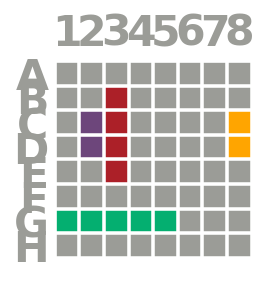

LLM Response:  yes
Human Response:  no
def answer(board):
    green_positions = np.argwhere(board == 'G')
    if len(green_positions) < 2:
        return 'No'
    return 'Yes' if green_positions[0][0] == green_positions[1][0] else 'No'
----------------------------------------
Question:  is the a horizantal dhip after g5 or h5
Board:  B03


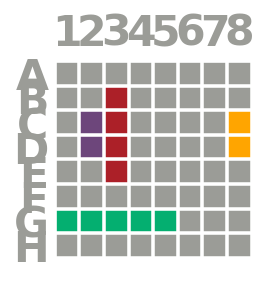

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if (board[6, 5] == board[6, 6] or board[7, 5] == board[7, 6]) else 'No'
----------------------------------------
Question:  is the final ship below g
Board:  B03


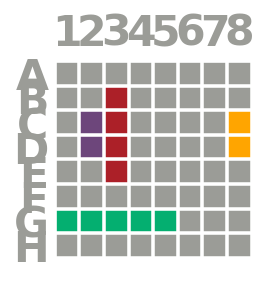

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[7, :] == 'W') else 'No'
----------------------------------------
Question:  is the ship horizontal?
Board:  B04


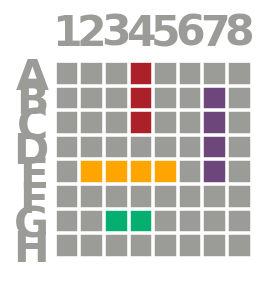

LLM Response:  yes
Human Response:  no
def answer(board):
    for row in board:
        if 'G' in row and list(row).count('G') > 1:
            return 'Yes'
        if 'R' in row and list(row).count('R') > 1:
            return 'Yes'
        if 'P' in row and list(row).count('P') > 1:
            return 'Yes'
        if 'O' in row and list(row).count('O') > 1:
            return 'Yes'
    return 'No'
----------------------------------------
Question:  is it vertical or horizontal?
Board:  B05


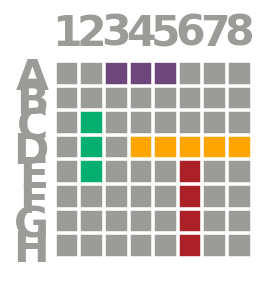

LLM Response:  vertical
Human Response:  yes
def answer(board):
    # Check for vertical orientation
    for col in range(board.shape[1]):
        for row in range(board.shape[0] - 1):
            if board[row, col] == board[row + 1, col] and board[row, col] != 'W':
                return 'Vertical'
    
    # Check for horizontal orientation
    for row in range(board.shape[0]):
        for col in range(board.shape[1] - 1):
            if board[row, col] == board[row, col + 1] and board[row, col] != 'W':
                return 'Horizontal'
    
    return 'Unknown'
----------------------------------------
Question:  is orange vertical
Board:  B02


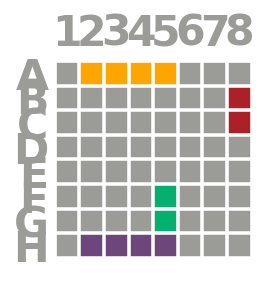

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.all(board[0, 1:5] == 'O') else 'No'
----------------------------------------
Question:  is one on f after 5 or on g
Board:  B02


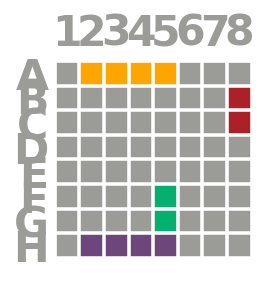

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if board[5, 4] == 'G' or board[6, 0] == 'G' else 'No'
----------------------------------------
Question:  are any ships directly below the orange and green ships meaning any part of them directly under?
Board:  B01


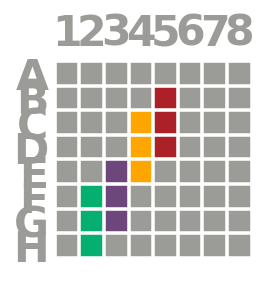

LLM Response:  yes
Human Response:  no
def answer(board):
    orange_positions = np.argwhere(board == 'O')
    green_positions = np.argwhere(board == 'G')
    
    for pos in orange_positions:
        if pos[0] + 1 < board.shape[0] and board[pos[0] + 1, pos[1]] != 'W':
            return 'Yes'
    
    for pos in green_positions:
        if pos[0] + 1 < board.shape[0] and board[pos[0] + 1, pos[1]] != 'W':
            return 'Yes'
    
    return 'No'
----------------------------------------
Question:  is it on row e?
Board:  B01


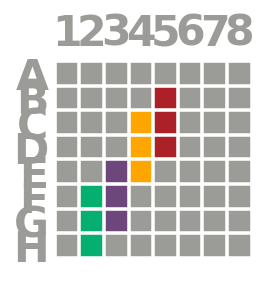

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[4] != 'W') else 'No'
----------------------------------------
Question:  is it on column 5?
Board:  B01


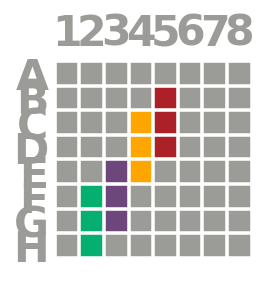

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 4] != 'W') else 'No'
----------------------------------------
Question:  is the green ship in the upper half?
Board:  B06


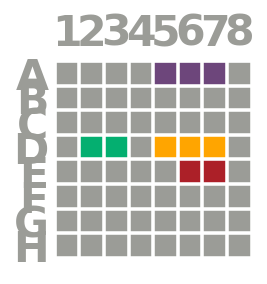

LLM Response:  yes
Human Response:  no
def answer(board):
    green_positions = np.where(board == 'G')
    return 'Yes' if np.any(green_positions[0] < 4) else 'No'
----------------------------------------
Question:  is the green ship on the left half?
Board:  B06


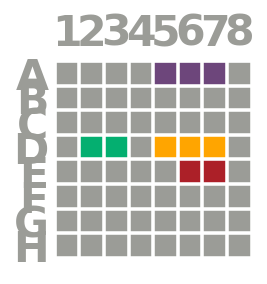

LLM Response:  yes
Human Response:  no
def answer(board):
    green_positions = np.where(board == 'G')
    return 'Yes' if np.any(green_positions[1] < 4) else 'No'
----------------------------------------
Question:  does th green ship touch the center of its quadrant?
Board:  B06


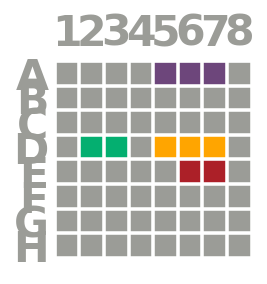

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if board[3, 2] == 'G' else 'No'
----------------------------------------
Question:  are there more than two ships that touch eachother?
Board:  B06


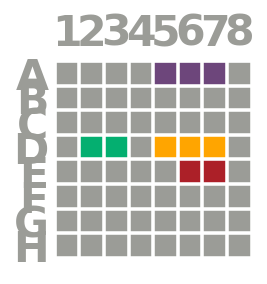

LLM Response:  yes
Human Response:  no
def answer(board):
    # Check for adjacent ships
    def is_adjacent(x, y):
        ship_types = {'G', 'R', 'P', 'O'}
        if board[x, y] not in ship_types:
            return False
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < board.shape[0] and 0 <= ny < board.shape[1]:
                if board[nx, ny] in ship_types and board[nx, ny] != board[x, y]:
                    return True
        return False

    adjacent_count = 0
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            if is_adjacent(i, j):
                adjacent_count += 1
                if adjacent_count > 2:
                    return 'Yes'
    return 'No'
----------------------------------------
Question:  is it vertical?
Board:  B04


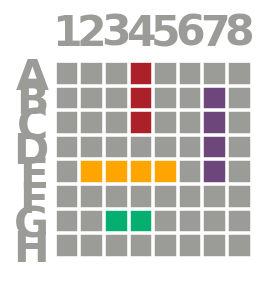

LLM Response:  yes
Human Response:  no
def answer(board):
    # Check for vertical ships
    for col in range(board.shape[1]):
        for row in range(board.shape[0] - 1):
            if board[row, col] != 'W' and board[row, col] == board[row + 1, col]:
                return 'Yes'
    return 'No'
----------------------------------------
Question:  any more ships in row b?
Board:  B08


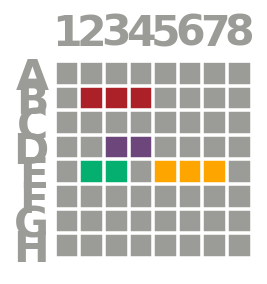

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[1] != 'W') else 'No'
----------------------------------------
Question:  row f?
Board:  B08


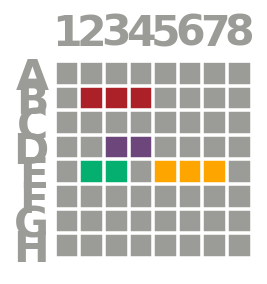

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if 'W' in board[5] else 'No'
----------------------------------------
Question:  row g?
Board:  B08


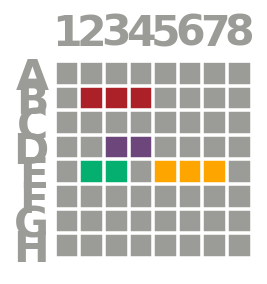

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if 'W' in board[6] else 'No'
----------------------------------------
Question:  nothing in row g?
Board:  B08


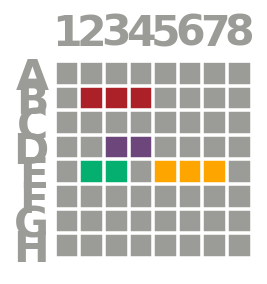

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.all(board[6] == 'W') else 'No'
----------------------------------------
Question:  row b?
Board:  B17


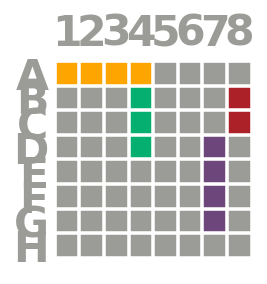

LLM Response:  True
Human Response:  yes
def answer(board):
    return 'G' in board[1] or 'R' in board[1] or 'P' in board[1] or 'O' in board[1]
----------------------------------------
Question:  horizontal?
Board:  B17


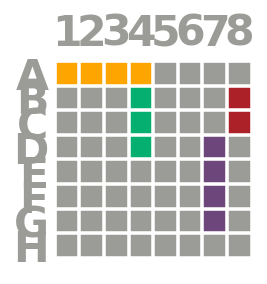

LLM Response:  yes
Human Response:  no
def answer(board):
    for row in board:
        if 'G' in row and list(row).count('G') > 1:
            return 'Yes'
        if 'R' in row and list(row).count('R') > 1:
            return 'Yes'
        if 'P' in row and list(row).count('P') > 1:
            return 'Yes'
        if 'O' in row and list(row).count('O') > 1:
            return 'Yes'
    return 'No'
----------------------------------------
Question:  horizontal?
Board:  B17


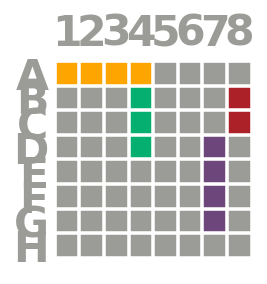

LLM Response:  yes
Human Response:  no
def answer(board):
    for row in board:
        if 'G' in row and list(row).count('G') > 1:
            return 'Yes'
        if 'R' in row and list(row).count('R') > 1:
            return 'Yes'
        if 'P' in row and list(row).count('P') > 1:
            return 'Yes'
        if 'O' in row and list(row).count('O') > 1:
            return 'Yes'
    return 'No'
----------------------------------------
Question:  c 1-3?
Board:  B17


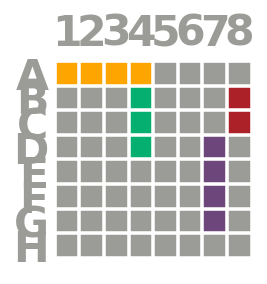

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.all(board[2, 0:3] == 'W') else 'No'
----------------------------------------
Question:  any ships in column 8?
Board:  B17


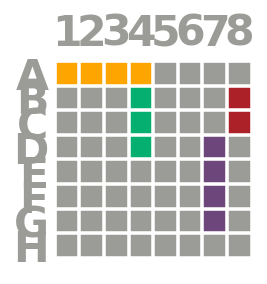

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 7] != 'W') else 'No'
----------------------------------------
Question:  are there any ships close to the red ship?
Board:  B11


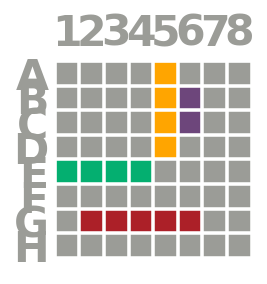

LLM Response:  no
Human Response:  yes
def answer(board):
    red_positions = np.argwhere(board == 'R')
    for r, c in red_positions:
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                nr, nc = r + dr, c + dc
                if 0 <= nr < board.shape[0] and 0 <= nc < board.shape[1]:
                    if board[nr, nc] in ['G', 'O', 'P']:
                        return 'Yes'
    return 'No'
----------------------------------------
Question:  is the green ship close by the other ships?
Board:  B11


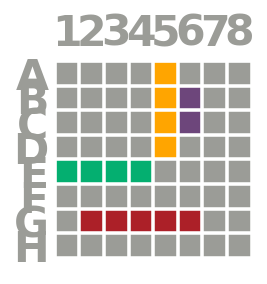

LLM Response:  yes
Human Response:  no
def answer(board):
    green_positions = np.argwhere(board == 'G')
    for pos in green_positions:
        row, col = pos
        neighbors = board[max(0, row-1):row+2, max(0, col-1):col+2]
        if np.any(np.isin(neighbors, ['R', 'P', 'O'])):
            return 'Yes'
    return 'No'
----------------------------------------
Question:  should i move left to find the red ship?
Board:  B17


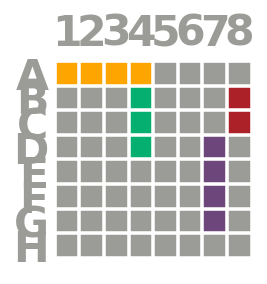

LLM Response:  yes
Human Response:  no
def answer(board):
    red_ship_positions = np.where(board == 'R')
    if len(red_ship_positions[1]) > 0 and np.any(red_ship_positions[1] > 0):
        return 'Yes'
    return 'No'
----------------------------------------
Question:  is orange to the right?
Board:  B17


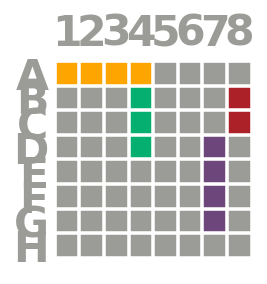

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 1:] == 'O') else 'No'
----------------------------------------
Question:  should i try the bottom half of the board?
Board:  B17


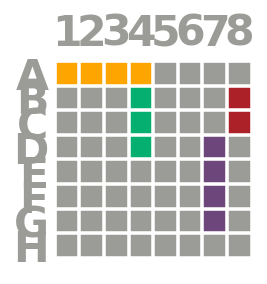

LLM Response:  yes
Human Response:  no
def answer(board):
    bottom_half = board[4:]
    return 'Yes' if np.any(bottom_half != 'W') else 'No'
----------------------------------------
Question:  should i go up?
Board:  B17


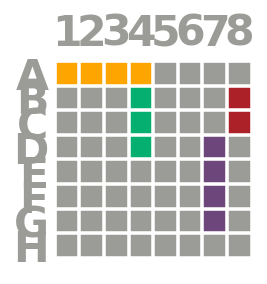

LLM Response:  no
Human Response:  yes
def answer(board):
    # Check if there is any ship part in the row above the current position
    current_row = np.where(board == 'R')[0][0]  # Assuming current position is on the red ship
    if current_row > 0 and 'W' not in board[current_row - 1]:
        return 'Yes'
    return 'No'
----------------------------------------
Question:  are any ships in the middle? i.e ships not touching the outer 2 layers. (border 1 and 2)
Board:  B12


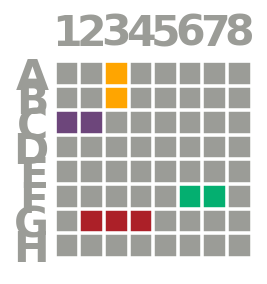

LLM Response:  yes
Human Response:  no
def answer(board):
    inner_board = board[2:6, 2:6]
    return 'Yes' if np.any(inner_board != 'W') else 'No'
----------------------------------------
Question:  is it horizontal?
Board:  B12


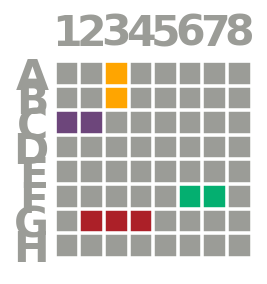

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(np.all(board == 'O', axis=1)) else 'No'
----------------------------------------
Question:  is the top half ship on the border?
Board:  B12


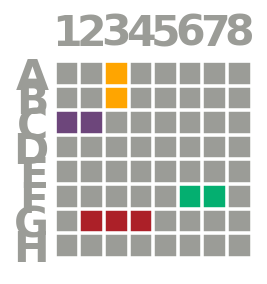

LLM Response:  no
Human Response:  yes
def answer(board):
    top_half = board[:4, :]
    return 'Yes' if 'G' in top_half[0, :] or 'G' in top_half[:, 0] or 'G' in top_half[:, -1] else 'No'
----------------------------------------
Question:  does it touch the red ship?
Board:  B12


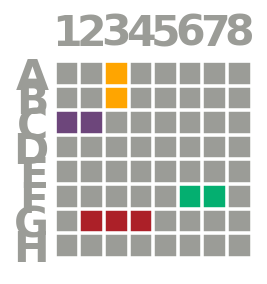

LLM Response:  yes
Human Response:  no
def answer(board):
    red_positions = np.argwhere(board == 'R')
    for r, c in red_positions:
        if (r > 0 and board[r-1, c] != 'W') or (r < 7 and board[r+1, c] != 'W') or \
           (c > 0 and board[r, c-1] != 'W') or (c < 7 and board[r, c+1] != 'W'):
            return 'Yes'
    return 'No'
----------------------------------------
Question:  top half = yes bottom half = no
Board:  B12


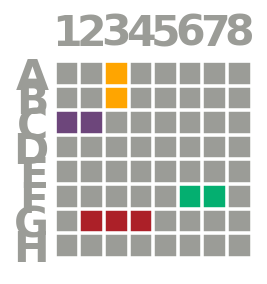

LLM Response:  no
Human Response:  yes
def answer(board):
    top_half = board[:4]
    bottom_half = board[4:]
    return 'Yes' if np.any(top_half == 'R') else 'No'
----------------------------------------
Question:  1-4 yes, 5-8 no
Board:  B12


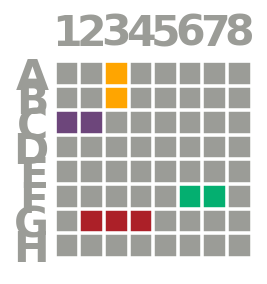

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if np.all(board[0, 0:4] != 'W') and np.all(board[0, 4:8] == 'W') else 'No'
----------------------------------------
Question:  touching orange?
Board:  B12


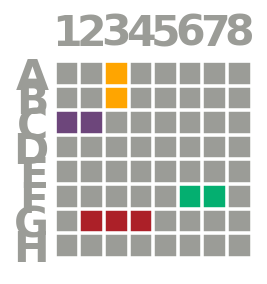

LLM Response:  yes
Human Response:  no
def answer(board):
    orange_positions = np.argwhere(board == 'O')
    for pos in orange_positions:
        row, col = pos
        # Check adjacent cells
        if (row > 0 and board[row - 1, col] != 'W') or \
           (row < board.shape[0] - 1 and board[row + 1, col] != 'W') or \
           (col > 0 and board[row, col - 1] != 'W') or \
           (col < board.shape[1] - 1 and board[row, col + 1] != 'W'):
            return 'Yes'
    return 'No'
----------------------------------------
Question:  are any ships touching alongside each other
Board:  B09


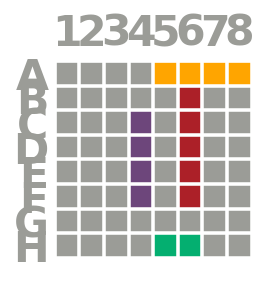

LLM Response:  no
Human Response:  yes
def answer(board):
    for i in range(board.shape[0] - 1):
        for j in range(board.shape[1] - 1):
            if board[i, j] != 'W':
                if board[i, j] == board[i + 1, j] or board[i, j] == board[i, j + 1]:
                    continue
                if board[i + 1, j] != 'W' and board[i + 1, j] != board[i, j]:
                    return 'Yes'
                if board[i, j + 1] != 'W' and board[i, j + 1] != board[i, j]:
                    return 'Yes'
    return 'No'
----------------------------------------
Question:  does the remaining ship touch one of the other ships?
Board:  B09


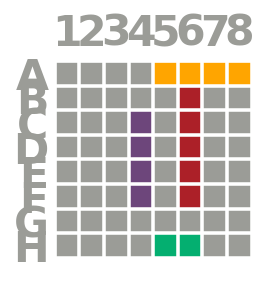

LLM Response:  yes
Human Response:  no
def answer(board):
    # Check for adjacent ships
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            if board[i, j] != 'W':
                # Check right
                if j < board.shape[1] - 1 and board[i, j] != board[i, j + 1] and board[i, j + 1] != 'W':
                    return 'Yes'
                # Check down
                if i < board.shape[0] - 1 and board[i, j] != board[i + 1, j] and board[i + 1, j] != 'W':
                    return 'Yes'
    return 'No'
----------------------------------------
Question:  are there other ships in this upper right quadrant?
Board:  B18


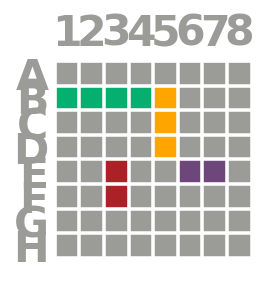

LLM Response:  yes
Human Response:  no
def answer(board):
    upper_right_quadrant = board[:4, 4:]
    return 'Yes' if np.any(np.isin(upper_right_quadrant, ['G', 'R', 'P', 'O'])) else 'No'
----------------------------------------
Question:  does it touch either right side or left side
Board:  B18


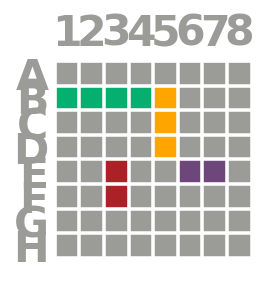

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if 'G' in board[:, 0] or 'G' in board[:, -1] or \
                   'R' in board[:, 0] or 'R' in board[:, -1] or \
                   'P' in board[:, 0] or 'P' in board[:, -1] or \
                   'O' in board[:, 0] or 'O' in board[:, -1] else 'No'
----------------------------------------


In [11]:
from ast import literal_eval
from pathlib import Path

for cache_key in code_spotter_accuracy[1]:
    cache_file = Path("./cache") / "CodeSpotterModel" / f"{cache_key[0]}.txt"
    if cache_file.exists():
        cache_dict = literal_eval(cache_file.read_text())
        question_board = cache_key[0].replace("_", " ")
        question = " ".join(question_board.split(" ")[:-1])
        board = question_board.split(" ")[-1]
        print("Question: ", question)
        print("Board: ", board)
        display(Board.from_trial_id(board).to_figure(2))
        print("LLM Response: ", cache_key[1][0])
        print("Human Response: ", cache_key[1][1])
        print(cache_dict["code"])
        print("-"*40)


# DirectSpotter

In [7]:
code_spotter_accuracy = benchmark_on_rounds(df, rounds_questions_dict, DirectSpotterModel, max_rounds=20, max_questions=20, use_history=False, use_cache=False, use_captain_board=True)
code_spotter_accuracy[0], code_spotter_accuracy[1]

Round 01JJ7XE7JD29BEKTD8K2YMZW8B, 13/20:  75%|███████▌  | 3/4 [00:01<00:00,  2.07it/s]

Error with decision id 15
Error with decision id 17


Round 01JJ8BHRK7THZ5A14XESXTCCJZ, 15/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.50it/s]

Error with decision id 32


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:   0%|          | 0/13 [00:00<?, ?it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:   8%|▊         | 1/13 [00:00<00:07,  1.61it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  15%|█▌        | 2/13 [00:01<00:06,  1.77it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  23%|██▎       | 3/13 [00:01<00:05,  1.89it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  31%|███       | 4/13 [00:02<00:04,  1.88it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  38%|███▊      | 5/13 [00:02<00:03,  2.01it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  46%|████▌     | 6/13 [00:03<00:03,  1.82it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  54%|█████▍    | 7/13 [00:03<00:03,  1.99it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  62%|██████▏   | 8/13 [00:04<00:02,  1.98it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  69%|██████▉   | 9/13 [00:04<00:02,  1.73it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  77%|███████▋  | 10/13 [00:05<00:01,  1.72it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  85%|████████▍ | 11/13 [00:06<00:01,  1.68it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  92%|█████████▏| 12/13 [00:06<00:00,  1.79it/s]

Error with decision id 1


Round 01JJX5ZAZ3M6RG9F3ZCB0H4SBY, 18/20: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


(0.7213114754098361,
 [['is_green_ship_horizantal?_B03', ('yes', 'no')],
  ['is_there_a_ship_below_f3_B03', ('no', 'yes')],
  ['is_there_now_2_ships_that_are_fully_sunk_B03', ('yes', 'no')],
  ['is_there_a_ship_to_the_left_of_green_B03', ('no', 'yes')],
  ['is_the_ship_horizontal?_B04', ('no', 'yes')],
  ['is_it_vertical_or_horizontal?_B05', ('no', 'yes')],
  ['nobody_lied_a2_is_on_or_before_c6_or_d6?"_B02', ('no', 'yes')],
  ['is_on_row_246_or_8_B02', ('no', 'yes')],
  ['is_it_on_c_B02', ('no', 'yes')],
  ['is_it_above_c_but_before_or_on_5_B02', ('no', 'yes')],
  ['is__ther_a_ship_on_or_above_d_B02', ('no', 'yes')],
  ['is_ther_a_ship_above_e_but_after_5_B02', ('no', 'yes')],
  ['is_one_on_f_after_5_or_on_g_B02', ('yes', 'no')],
  ['are_there_any_ships_directly_to_the_left_of_the_two_known_ships_B01',
   ('no', 'yes')],
  ['is_it_on_row_e?_B01', ('yes', 'no')],
  ['is_it_on_column_5?_B01', ('yes', 'no')],
  ['yo_uare_clearly_sabotaging_this._saying_it_is_on_row_g_that_is_impossible._i

In [17]:
code_spotter_accuracy = benchmark_on_rounds(df, rounds_questions_dict, DirectSpotterModel, max_rounds=20, max_questions=20, use_history=False, use_cache=False, use_captain_board=False)
code_spotter_accuracy[0], code_spotter_accuracy[1]

Round 01JJ7XE7JD29BEKTD8K2YMZW8B, 13/20:  75%|███████▌  | 3/4 [00:01<00:00,  2.02it/s]

Error with decision id 15
Error with decision id 17


Round 01JJ8BHRK7THZ5A14XESXTCCJZ, 15/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.80it/s]

Error with decision id 32


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:   0%|          | 0/13 [00:00<?, ?it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:   8%|▊         | 1/13 [00:00<00:06,  1.87it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  15%|█▌        | 2/13 [00:00<00:04,  2.25it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  23%|██▎       | 3/13 [00:01<00:04,  2.08it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  31%|███       | 4/13 [00:01<00:04,  2.08it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  38%|███▊      | 5/13 [00:02<00:03,  2.26it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  46%|████▌     | 6/13 [00:02<00:02,  2.45it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  54%|█████▍    | 7/13 [00:03<00:02,  2.54it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  62%|██████▏   | 8/13 [00:03<00:02,  2.10it/s]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  69%|██████▉   | 9/13 [00:07<00:06,  1.59s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  77%|███████▋  | 10/13 [00:08<00:03,  1.22s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  85%|████████▍ | 11/13 [00:09<00:02,  1.21s/it]

Error with decision id 1


Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA, 16/20:  92%|█████████▏| 12/13 [00:09<00:00,  1.01it/s]

Error with decision id 1


Round 01JJX5ZAZ3M6RG9F3ZCB0H4SBY, 18/20: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


(0.73224043715847,
 [['is_green_ship_horizantal?_B03', ('yes', 'no')],
  ['is_there_a_ship_below_f3_B03', ('no', 'yes')],
  ['is_there_a_ship_to_the_left_of_green_B03', ('no', 'yes')],
  ['is_the_ship_horizontal?_B04', ('no', 'yes')],
  ['are_there_any_parts_of_a_boat_in_the_square_a-c_and_1-3_B05',
   ('no', 'yes')],
  ['are_there_ship_parts_in_column_8?_B05', ('no', 'yes')],
  ['is_it_vertical_or_horizontal?_B05', ('no', 'yes')],
  ['is_there_parts_of_the_boat_in_column_8_in_rows_d,_e,_or_f?_B05',
   ('no', 'yes')],
  ['is_on_row_246_or_8_B02', ('no', 'yes')],
  ['is_it_on_c_B02', ('no', 'yes')],
  ['is_it_above_c_but_before_or_on_5_B02', ('no', 'yes')],
  ['is__ther_a_ship_on_or_above_d_B02', ('no', 'yes')],
  ['is_ther_a_ship_above_e_but_after_5_B02', ('no', 'yes')],
  ['are_there_any_ships_directly_to_the_left_of_the_two_known_ships_B01',
   ('no', 'yes')],
  ['is_it_on_row_e?_B01', ('yes', 'no')],
  ['is_it_on_column_5?_B01', ('yes', 'no')],
  ['is_the_green_ship_on_the_left_half

Question:  is green ship horizantal?
Board:  B03


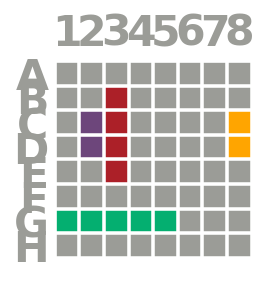

LLM Response:  yes
Human Response:  no
None
----------------------------------------
Question:  is there a ship below f3
Board:  B03


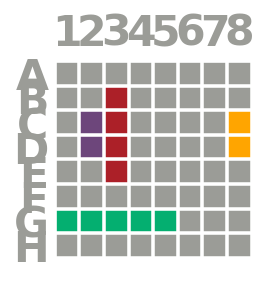

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is there a ship to the left of green
Board:  B03


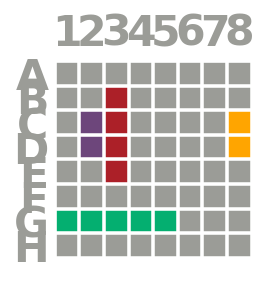

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is the ship horizontal?
Board:  B04


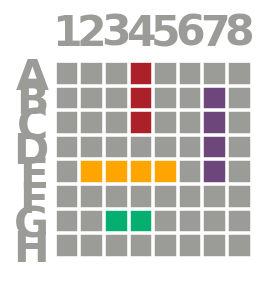

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  are there any parts of a boat in the square a-c and 1-3
Board:  B05


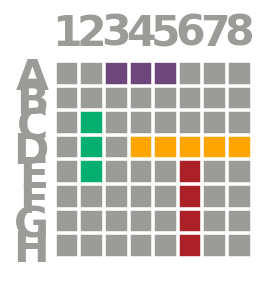

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  are there ship parts in column 8?
Board:  B05


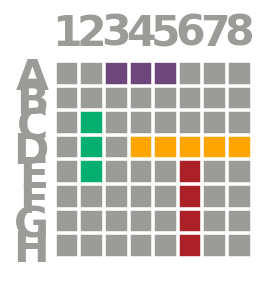

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is it vertical or horizontal?
Board:  B05


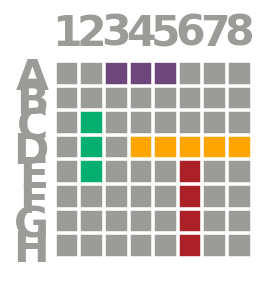

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is there parts of the boat in column 8 in rows d, e, or f?
Board:  B05


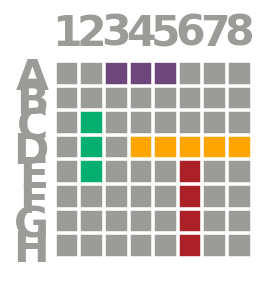

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is on row 246 or 8
Board:  B02


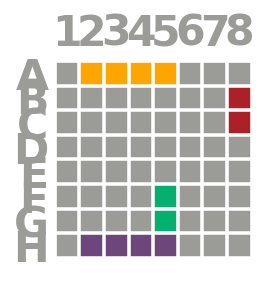

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is it on c
Board:  B02


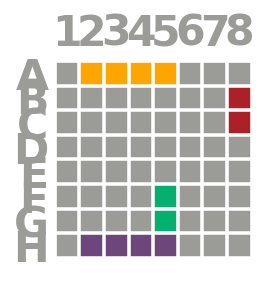

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is it above c but before or on 5
Board:  B02


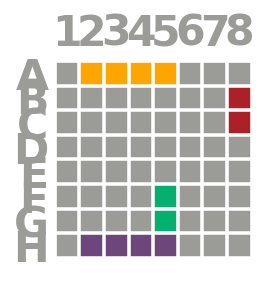

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is  ther a ship on or above d
Board:  B02


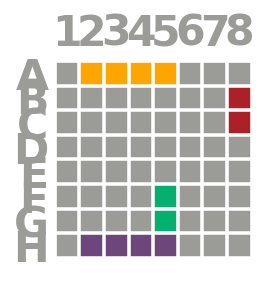

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is ther a ship above e but after 5
Board:  B02


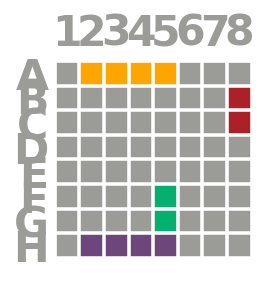

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  are there any ships directly to the left of the two known ships
Board:  B01


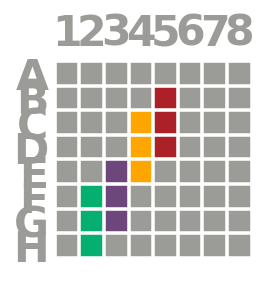

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is it on row e?
Board:  B01


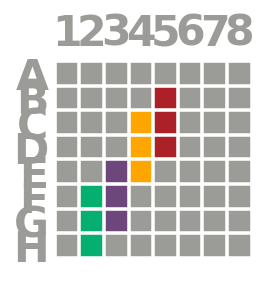

LLM Response:  yes
Human Response:  no
None
----------------------------------------
Question:  is it on column 5?
Board:  B01


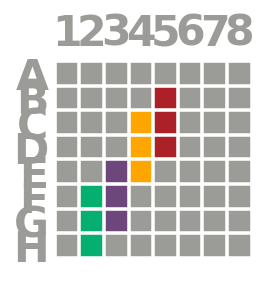

LLM Response:  yes
Human Response:  no
None
----------------------------------------
Question:  is the green ship on the left half?
Board:  B06


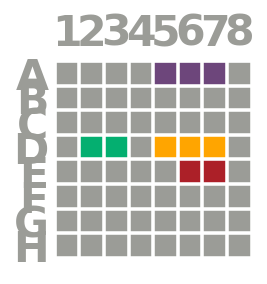

LLM Response:  yes
Human Response:  no
None
----------------------------------------
Question:  does th green ship touch the center of its quadrant?
Board:  B06


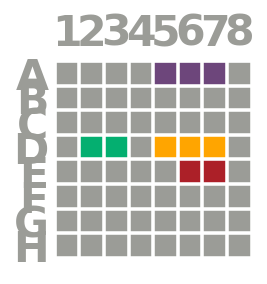

LLM Response:  yes
Human Response:  no
None
----------------------------------------
Question:  does the green ship have three spots?
Board:  B06


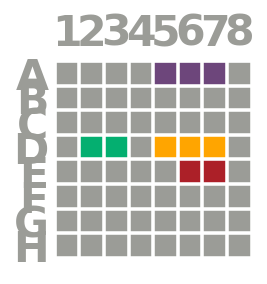

LLM Response:  yes
Human Response:  no
None
----------------------------------------
Question:  do any ships touch the center four squares?
Board:  B06


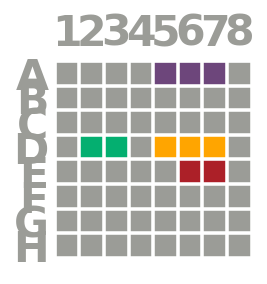

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  do any ships touch the edges?
Board:  B06


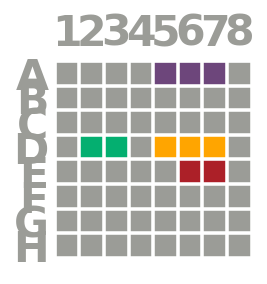

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  do any ships touch eachother?
Board:  B06


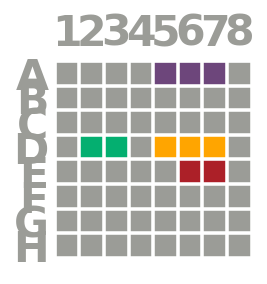

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  any in column 2?
Board:  B04


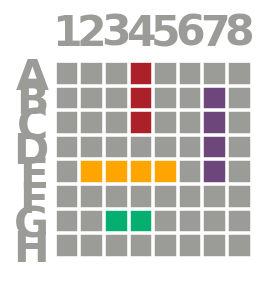

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is the last ship on the top half of the map (a-d)?
Board:  B04


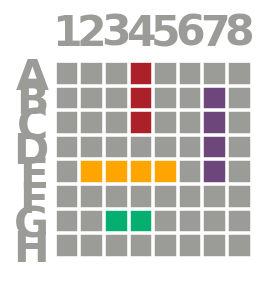

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  row d?
Board:  B08


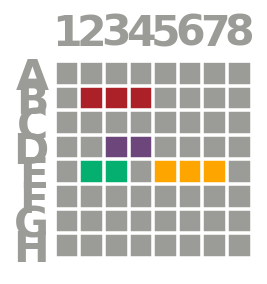

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  any more ships in row e?
Board:  B08


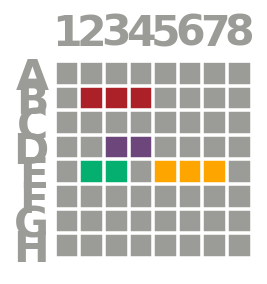

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  column 1-4?
Board:  B08


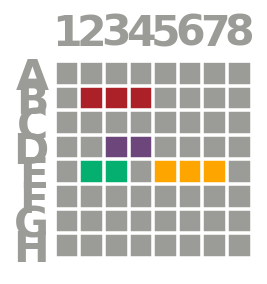

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  nothing in row g?
Board:  B08


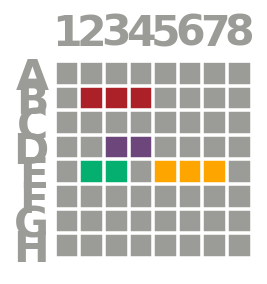

LLM Response:  yes
Human Response:  no
None
----------------------------------------
Question:  horizontal?
Board:  B17


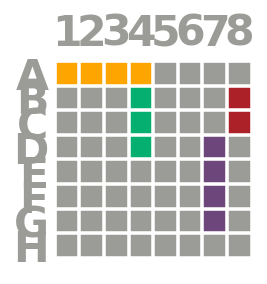

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  row b?
Board:  B17


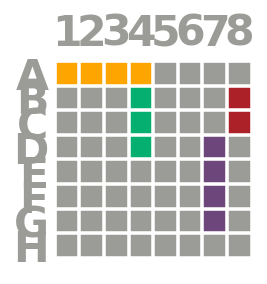

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  any ships in column 8?
Board:  B17


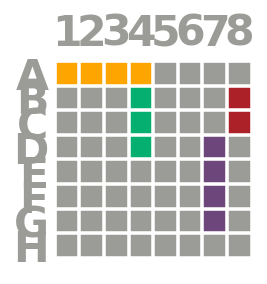

LLM Response:  yes
Human Response:  no
None
----------------------------------------
Question:  7?
Board:  B17


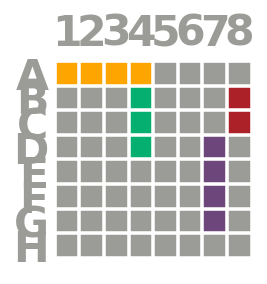

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is there a ship on column e across?
Board:  B01


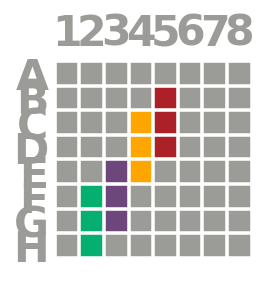

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is there another ship in the bottom left side?
Board:  B01


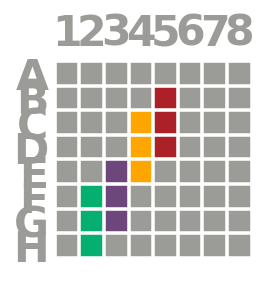

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is there another ship on line g across
Board:  B01


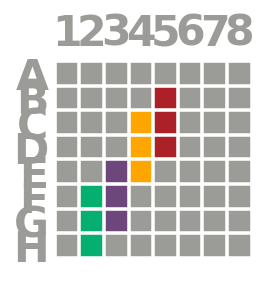

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  are there any ships close to the red ship?
Board:  B11


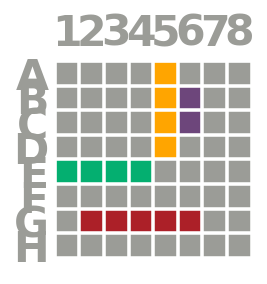

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is there any ships on column 8 down?
Board:  B17


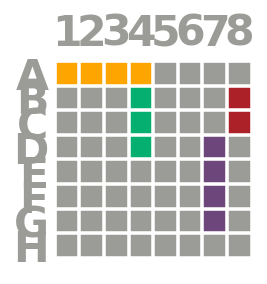

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  should i go up?
Board:  B17


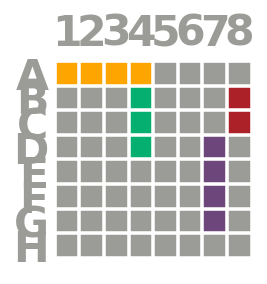

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  any ships touching column 8
Board:  B16


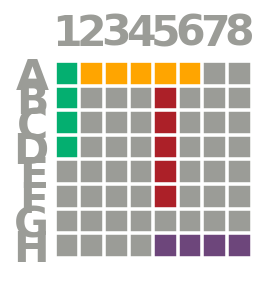

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  for the middle ship. even = yes odd = no
Board:  B12


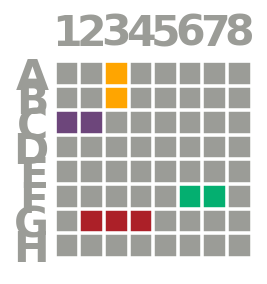

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  is it horizontal?
Board:  B12


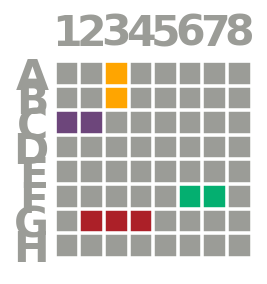

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  1-4 = yes, 5-8 = no
Board:  B12


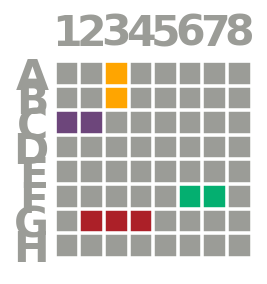

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  1-4 yes, 5-8 no
Board:  B12


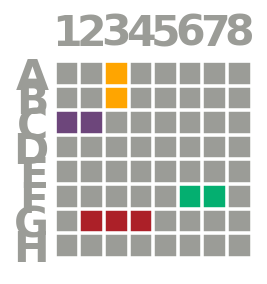

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  are any ships touching alongside each other
Board:  B09


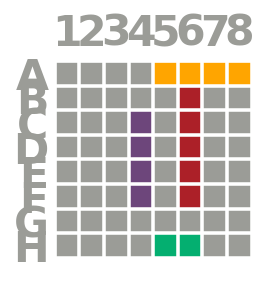

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  are there other ships in the upper or lower right quadrants?
Board:  B09


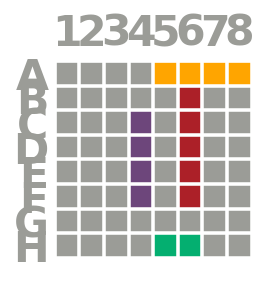

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  are they in column 8
Board:  B09


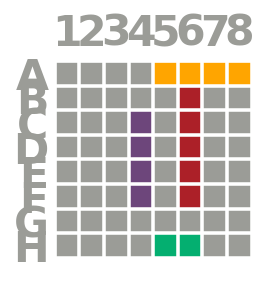

LLM Response:  no
Human Response:  yes
None
----------------------------------------
Question:  e5?
Board:  B18


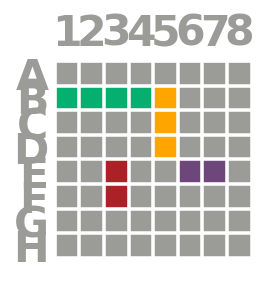

LLM Response:  w
Human Response:  no
None
----------------------------------------
Question:  d5?
Board:  B18


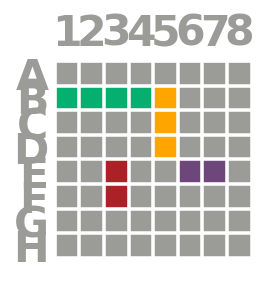

LLM Response:  o
Human Response:  yes
None
----------------------------------------
Question:  do any other ships touch this one?
Board:  B18


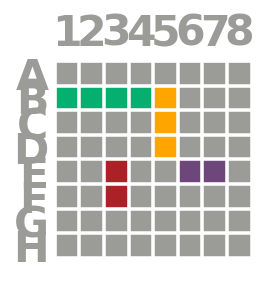

LLM Response:  no
Human Response:  yes
None
----------------------------------------


In [18]:
from ast import literal_eval
from pathlib import Path

for cache_key in code_spotter_accuracy[1]:
    cache_file = Path("./cache") / "DirectSpotterModel" / f"{cache_key[0]}.txt"
    if cache_file.exists():
        cache_dict = literal_eval(cache_file.read_text())
        question_board = cache_key[0].replace("_", " ")
        question = " ".join(question_board.split(" ")[:-1])
        board = question_board.split(" ")[-1]
        print("Question: ", question)
        print("Board: ", board)
        display(Board.from_trial_id(board).to_figure(2))
        print("LLM Response: ", cache_key[1][0])
        print("Human Response: ", cache_key[1][1])
        print(cache_dict["code"])
        print("-"*40)
